# Improving understanding of groundwater flow in an alpine karst system by reconstructing its geologic history using conduit network model ensembles #

**Authors:** Chloé Fandel, Ty Ferré, François Miville, Philippe Renard, Nico Goldscheider.

**Keywords:** groundwater, modeling, karst, anisotropic fast marching, conduit networks, hypothesis testing, paleo-springs, karst evolution 

**Note:** Because this model has a stochastic element, each run is slightly different. To exactly reproduce the figures in the paper, uncomment the lines of code setting random seeds. To see new randomly-generated results each time, comment out these same lines. The figures in this notebook will then not exactly match the published figures. 

**Filenames:**
- hypothesis 1: glacier covering all springs except paleo-spring, & all inlets connect to paleo-spring
- hypothesis 1b: same as 1, but the Ifersguntenalpe area drains to its own spring and is not connected to the rest of the system
- hypothesis 2: Sägebach spring is covered, and is replaced by the paleo-spring, which is not connected to the rest of the system
- hypothesis 2b: same as 2, but the paleo-spring connects to Aubach spring, which is the lowest spring in the system
- hypothesis 3: first there was glaciation, then all the springs except Sägebach were exposed, then Sägebach was uncovered.


## Setup, imports, & functions ##
This section imports all needed packages and local modules and defines custom plotting functions.

In [1]:
#Import standard modules:
import os            
import sys           
import importlib
import copy
import time
import numpy as np
import pandas as pd
import matplotlib
from matplotlib import pyplot as plt

#PyKasso-related imports:
import karstnet as kn
import pykasso as pk
#all fast-marching-related imports
import agd
from agd import Eikonal
from agd.Metrics import Riemann

#Local modules:
#import importlib.util

##spec = importlib.util.spec_from_file_location('swmmpy', 'C:/Users/Chloe/Documents/GitHub/gottesacker/swmmpy.py')

#spec = importlib.util.spec_from_file_location('swmmpy', 'C:/Users/cfandel/GitHub/pyKasso/pykasso/swmmpy.py')
#sp = importlib.util.module_from_spec(spec)
#spec.loader.exec_module(sp)

os.getcwd()           #show current working directory

'C:\\Users\\cfandel\\GitHub\\pyKasso\\notebooks'

In [8]:
#If you have trouble importing pykasso, or you want to be able to make and test changes to the source code:
#Download the entire repository as a zipped folder and import a local version of pyKasso 
#Set the path variable to the path to the local version. This also allows reloading the module to see changes.

run = False                       #set this line to True to run the code below
if run:
    sys.path.append('C:/Users/cfandel/GitHub/pyKasso/pykasso') #path to local version of package
    import base as pk  #in this case, "base" is the name of the .py file with all of the pykasso functions in it

#Check that it worked:
#catchment = pk.SKS() #uncomment this line to create a simple model
#You should see a printed statement indicating that you are using a development version of the package.
#If you do not see this statement, you are using the main version, and changes you make to the local version will have no effect.

In [2]:
#Define some custom functions for plotting:
def load_network(data, simplify=False, clean=False, plot=False, ax=None,  plot_nodes=False, labels=[], color='k', alpha=1, lw=1):
    """
    Show the base network as a graph with nodes and edges.

    Inputs: 
    data:   path & name prefix to node and edge data files (ex: folder/subfolder/yournamehere. Files MUST be named 'yournamehere_nodes.dat', and 'yournamehere_links.dat')
    simplify: True/False, whether to simplify network
    clean:  True/False, whether to clean up network
    plot:   True/False, whether to display plot at all or simply return network objects
    ax:     axis to plot on
    plot_nodes:   True/False, whether to display nodes
    labels: None or list of strings ['nodes','edges'], indicating which components to label
    color:  string, single color to use when plotting (cannot have both cmap and color)
    alpha:  float, opacity to plot with (1=opaque, 0=transparent)
    lw:     float, line width

    Outputs:
    k:     karstnet network object
    nodes: node dictionary
    edges: edge dictionary
    ax:    axes plotted on

    """
        
    #Load network:
    k = kn.from_nodlink_dat(data)   #load karstnet graph from files
    if simplify == True:
        nodes  = k.graph_simpl.nodes  #get indices of only the nodes in the simplified graph
        edges  = k.graph_simpl.edges  #get only the edges in the simplified graph
        if clean == True:             #remove erroneous edges (identify them manually by plotting)
            k.graph_simpl.remove_edge(15,1713)  
            k.graph_simpl.remove_edge(17,1644)  
            k.graph_simpl.remove_edge(23,1644)  
            k.graph_simpl.remove_edge(23,1700)  
    else:
        nodes = k.graph.nodes             #get all node indices
        edges = k.graph.edges             #get all edges
        if clean == True:                 #remove erroneous edges (identify them manually by plotting)
            k.graph.remove_edge(4,1701)   #8
            k.graph.remove_edge(15,1702)  #23
            k.graph.remove_edge(17,1644)  #26
            k.graph.remove_edge(20,1701)  #30
            k.graph.remove_edge(23,1644)  #34
            k.graph.remove_edge(23,1700)  #35

    nodes_coord = k.pos2d                                                            #get coordinates of all nodes in complex graph
    nodes  = {node:[nodes_coord[node][0],nodes_coord[node][1]]  for node in nodes}   #make dictionary with node coordinates for plotting
    edges  = {i: edge for i,edge in enumerate(edges)}                                #make dictionary of edges for plotting
    nodes = pd.DataFrame.from_dict(nodes, orient='index', columns=['x','y'])         #convert to pandas for easier plotting
    edges = pd.DataFrame.from_dict(edges, orient='index', columns=['inNode','outNode'])

    #Plot network:
    if plot == True:
        if ax == None:
            fig,ax = plt.subplots(figsize=(10,10))  #create new axes if none are provided
            ax.set_aspect('equal')

        #Calculate start and end coordinates of edges:
        fromX = nodes.x.loc[edges.inNode]       
        fromY = nodes.y.loc[edges.inNode]
        toX   = nodes.x.loc[edges.outNode]
        toY   = nodes.y.loc[edges.outNode]

        #Plot nodes and edges:
        for ind in edges.index:                                                                 #loop over edge indices
            ax.plot((fromX.iloc[ind], toX.iloc[ind]), (fromY.iloc[ind], toY.iloc[ind]), c=color, alpha=alpha, lw=lw)  #plot each edge in same color
        if plot_nodes:
            ax.scatter(nodes.x, nodes.y,  c=color, s=5, alpha=alpha)  #scatterplot nodes
                
        #Add labels:
        if labels == None:
            pass
        else:
            if 'nodes' in labels:                                         #label node indices
                for ind in nodes.index:                                   #loop over node indices
                    ax.annotate(str(ind), xy=(nodes.x[ind]-10, nodes.y[ind]))  #annotate slightly to left of each node
            if 'edges' in labels:                                         
                for ind in edges.index:                                   
                    ax.annotate(str(ind), xy=(fromX.iloc[ind]-10, fromY.iloc[ind]))  #annotate slightly to left of in node of each edge

    return [k,nodes,edges,ax]  
   

def point2index(point, xmin,ymin,zmin, dx,dy,dz):
    '''Convert from x,y,z coordinates to i,j,k indices.'''
    x   = point[0]
    y   = point[1]
    z   = point[2]
    col = int((x - xmin) // dx)
    row = int((y - ymin) // dy)
    lay = int((z - zmin) // dz)
    
    return [col, row, lay]

#Color reference & custom colormaps
quaternary = '#FFF5DF'
sandstone = '#BDA380'
limestone = '#C4E6B3'
marl = '#F2D680'
flysch = '#D5B3E6'
#fractures = 'darkgray'
fractures = 'gainsboro'
water = 'dodgerblue'
#cave = '#732600'
cave = 'brown'
#swmm = '#a46908'
swmm = 'k'
conduits = 'teal'
ice = 'lightsteelblue'
out = 'white'

cmap_geo_hires = matplotlib.colors.ListedColormap([out,limestone,sandstone,marl,quaternary,flysch])   #geology colormap
colors = [out,limestone,sandstone,marl,quaternary,flysch]
cmap_geo_hires = matplotlib.colors.LinearSegmentedColormap.from_list('camp_geo_hires', colors)
cmap_geo = matplotlib.colors.ListedColormap([out,flysch,limestone,ice])   #geology colormap
cmap_frac = matplotlib.colors.ListedColormap([fractures])                 #fracture colormap
cmap_frac.set_under(color='w', alpha=0)                                   #set values under limit to transparent


## Gottesacker/Schwarzwassertal karst system ##
The extensively-studied Gottesacker/Schwarzwassertal karst system is located in the German/Austrian Alps (Goldscheider, 2005). This system consists of a series of plunging synclines and anticlines draining to the Schwarzwasser stream valley, which cuts roughly perpendicularly across the fold axes. The karst aquifer lies north of the valley in a limestone unit overlain by sandstone and underlain by non-karstifiable marl and older units (several other units are present, but for the purposes of conduit modeling, the geology has been simplified to only these four). Three major springs drain the system: an estavelle (QE, elevation 1120 m a.s.l.), the Aubach spring (QA, elevation 1080 m a.s.l.), and the Sägebach spring (QS, elevation 1035 m a.s.l.). South of the valley, unkarstifiable lithology prevents conduit development.

### Reference maps ###
This section simulates the entire network under present-day conditions. <br>

Map 1: same inputs and settings as in Fandel et al. 2022. <br>
Map 2: improved representation of geologic setting

CAUTION: You are using the development version of this package.

 This network contains  2  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd


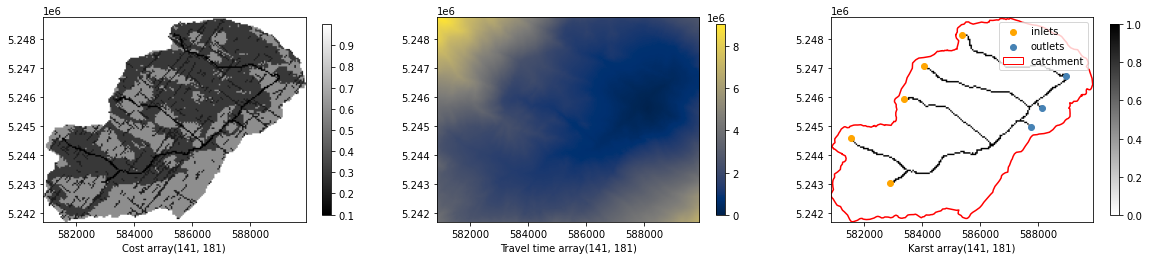

In [160]:
#Map 1: Same inputs and settings as in Fandel et al. 2022.
#Load model and simulate anisotropic network with multiple springs:
catchment = pk.SKS('inputs/paper3/settings_original.yaml')         #import settings and options from input folder
catchment.compute_karst_network()                         #run the model to calculate the karst network
catchment.set_rand_seed(1)                                #comment out this line to generate a random result
catchment.update_all()                                    #make changes take effect
catchment.show()

CAUTION: You are using the development version of this package.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd


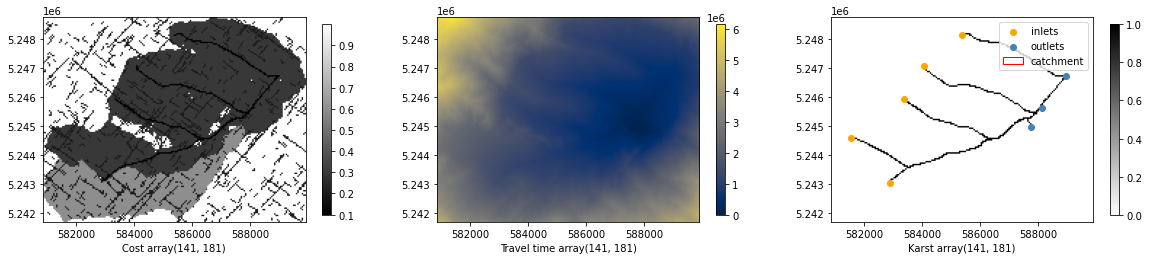

In [225]:
#Map 2: Update simulations to use improved geologic map and orientation information
#Geology updates: 2D projection of 3D geologic model indicating which cells have karstifiable limestone present at any depth
#Orientation updates: Use elevation of lower boundary of karstifiable limestone unit rather than land surface elevation.
catchment = pk.SKS('inputs/paper3/settings_new.yaml')          #import settings and options from input folder
catchment.set_rand_seed(1)                                     #return same results as in published paper (comment this line out to see random results)
catchment.update_all()                                         #update model for changes to take effect
catchment.compute_karst_network()                              #run the model to calculate the karst network
catchment.show()                                               #show a quick summary figure


 This network contains  1  connected components

Graph successfully created from file !


 This network contains  1  connected components

Graph successfully created from file !



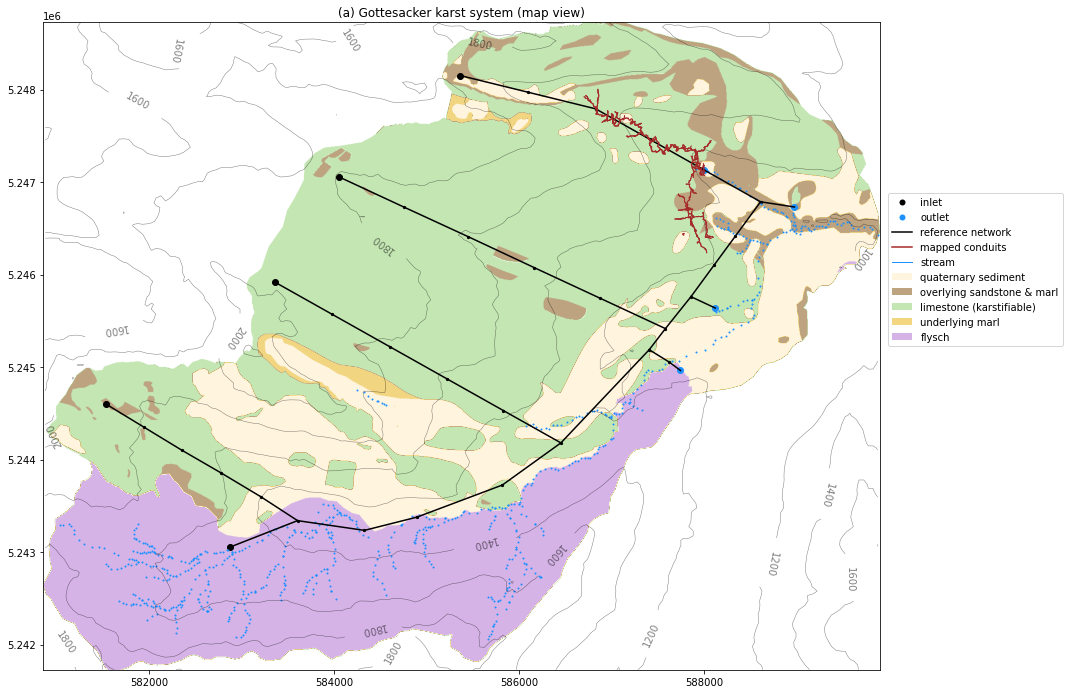

In [259]:
#Show a large figure of the present-day active conduit network based on tracer tests and updated model settings

f = plt.figure(figsize=(15,15))
ax = f.add_subplot(111, aspect='equal')  
ax.set_title('(a) Gottesacker karst system (map view)')

#Plot geology
geo_hires = np.genfromtxt('inputs/paper3/geo3_1806x1404.csv', delimiter=',') #load high-resolution mapped geology from arcmap
#geo_hires = geo_hires.astype(int)                                             
plt.imshow(geo_hires, origin='lower', extent=catchment.grid.extent, cmap=cmap_geo_hires) #plot high-resolution mapped geology
#plt.imshow(catchment.get_geology(), origin='lower', extent=catchment.grid.extent, cmap=cmap_geo, alpha=0.5, vmax=3) #plot simple geology used for pykasso

#Plot fractures
#frac = catchment.geology.data['fractures']['data'].copy()                                           #get fracture array
#frac[frac<1] = -1                                                                                   #set all non-fracture cells under limit (prevents them from displaying)
#plt.imshow(frac,                    origin='lower', extent=catchment.grid.extent, cmap=cmap_frac,     vmin=0,vmax=1)

#PLot contour lines
c = plt.contour(catchment.grid.X,catchment.grid.Y, catchment.geology.data['topography']['data'], colors=['k'], alpha=0.5, linewidths=0.5)
plt.clabel(c, inline=True, inline_spacing=20, fontsize=10, fmt='%1.0f', rightside_up=False, use_clabeltext=True)

#Plot karst networks
load_network('inputs/paper3/base', plot=True, ax=ax, plot_nodes=True, lw=1.5, color=swmm)  #load reference network
load_network('inputs/paper3/holloch3D', clean=True, plot=True, ax=ax, color=cave)          #load mapped cave network
#catchment.show_network(ax=ax, data=catchment.karst_simulations[0], simplify=False, labels=[], plot_nodes=False, legend=False, color=conduits)
plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')           #plot inlets
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c=water)         #plot outlets (springs)
plt.scatter(588006.66, 5247129.20, c=water)                                  #plot overflow spring (not used in model)
streams = np.loadtxt('inputs/paper3/stream_points_all.csv', delimiter=',')   #load raw csv file of stream points
plt.scatter(streams[:,0], streams[:,1], c=water, s=1)                        #plot stream

#Legend and annotations:
label = False                                          #set to True to label inlets and outlets
if label:
    inlet_labels  = ['N21', 'N16', 'N1', 'N6', 'N11']  #incorrect order - don't use
    outlet_labels = ['QS', 'QE', 'QA']
    for i,inlet in enumerate(catchment.inlets):
        #ax.annotate(inlet_labels[i],  xy=(inlet[0]-400,  inlet[1]))
        ax.annotate(str(i), xy=(inlet[0]+100,inlet[1]+100),color='k')
    for o,outlet in enumerate(catchment.outlets):
        ax.annotate(outlet_labels[o], xy=(outlet[0]+100, outlet[1]), c=water)
    ax.annotate('QO', xy=(588006.66+100, 5247129.20), c=water)

legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='k', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor=water, markeredgecolor='none', label='outlet'),
          #matplotlib.lines.Line2D([0], [0], color='k',     lw=2,   label='simulated network'),
          matplotlib.lines.Line2D([0], [0], color=swmm,  lw=1.5, label='reference network'),
          matplotlib.lines.Line2D([0], [0], color=cave, lw=1.5,  label='mapped conduits'),
          #matplotlib.lines.Line2D([0], [0], color='gray', lw=0.5, label='contour'),
          #matplotlib.lines.Line2D([0], [0], color='k',    lw=1,   label='cross-section'),
          #matplotlib.lines.Line2D([0], [0], color='r',    lw=1,   label='boundary'),
          matplotlib.lines.Line2D([0], [0], color=water,  lw=1,   label='stream'),
          matplotlib.patches.Patch(facecolor=quaternary,label='quaternary sediment'),
          matplotlib.patches.Patch(facecolor=sandstone, label='overlying sandstone & marl'),
          matplotlib.patches.Patch(facecolor=limestone, label='limestone (karstifiable)'),
          matplotlib.patches.Patch(facecolor=marl,      label='underlying marl'),
          matplotlib.patches.Patch(facecolor=flysch,    label='flysch')]
plt.legend(handles=legend, loc=[1.01, 0.5]) #to put on right side: loc=[1.01,0.5], to put in right corner: loc=[0.72,0.01], to put in left corner: loc=[0.01,0.01]

In [17]:
#Calculate multiple iterations:
n             = 100               #number of iterations
shuffle       = False            #whether to shuffle inlet/outlet order

catchment = pk.SKS('inputs/paper3/settings_new.yaml') #import settings and options from input folder

if shuffle:
    catchment.set_inlets_shuffle(True)                                    #shuffle inlet order each run
    
for i in range(n):
    catchment.update_all()
    catchment.compute_karst_network()                               #run the model to calculate the karst network
    #catchment.show()

CAUTION: You are using the development version of this package.

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  1  connected components

Computing:
 - mean length,cv length,length entropy,mean 

shuffle =  False

 This network contains  1  connected components

Graph successfully created from file !



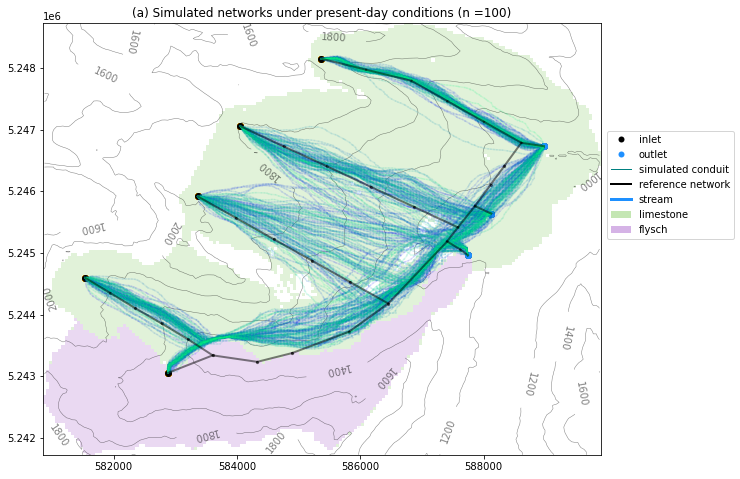

In [18]:
#Plot many iterations of the present-day conduit network:
print('shuffle = ', shuffle)

f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111, aspect='equal')
if shuffle:
    ax.set_title('(b) Present day conditions - random inlet/outlet assignment (n ='+str(n)+')')
else:
    ax.set_title('(a) Simulated networks under present-day conditions (n ='+str(n)+')')

plt.imshow(catchment.get_geology(), origin='lower', extent=catchment.grid.extent, cmap=cmap_geo, vmax=3, alpha=0.5)
c = plt.contour(catchment.grid.X,catchment.grid.Y, catchment.geology.data['topography']['data'], colors=['k'], alpha=0.5, linewidths=0.5)
plt.clabel(c, inline=True, inline_spacing=20, fontsize=10, fmt='%1.0f', rightside_up=False, use_clabeltext=True)
for i in range(n):
    color = matplotlib.cm.winter(i/n)  #set color map for conduit simulations
    #alpha = 1/n  #make each run have transparency of 1% of run number, to create probability map
    alpha=10/n    #make each run have transparency of 10% of run number, to make even low-probability runs more visible
    catchment.show_network(ax=ax, data=catchment.karst_simulations[i], simplify=False, labels=[], plot_nodes=False, legend=False, color=color, alpha=alpha)
#load_network('inputs/paper3/holloch3D', clean=True, plot=True, ax=ax, color=cave)
load_network('inputs/paper3/base', plot=True, ax=ax, plot_nodes=True, lw=2, color=swmm, alpha=0.5)
plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c=water)
#ax.annotate('QO', xy=(catchment.outlets[:,0]+100, catchment.outlets[:,1]), c=water)

legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='k', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor=water, markeredgecolor='none', label='outlet'),
          matplotlib.lines.Line2D([0], [0], color=conduits,lw=1, label='simulated conduit'),
          matplotlib.lines.Line2D([0], [0], color=swmm,    lw=2, label='reference network'),
          #matplotlib.lines.Line2D([0], [0], color=cave,      lw=2, label='mapped conduit'),
          matplotlib.lines.Line2D([0], [0], color=water, lw=3, label='stream'),
          matplotlib.patches.Patch(facecolor=limestone, label='limestone'),
          matplotlib.patches.Patch(facecolor=flysch,  label='flysch')]
plt.legend(handles=legend, loc=[1.01, 0.5])

## Hölloch cave system ##
This section imports and plots the mapped conduits in the Hölloch cave system and displays some network statistics.


 This network contains  1  connected components

Graph successfully created from file !



c:\users\cfandel\github\karstnet\karstnet\base.py:353: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.tight_layout()


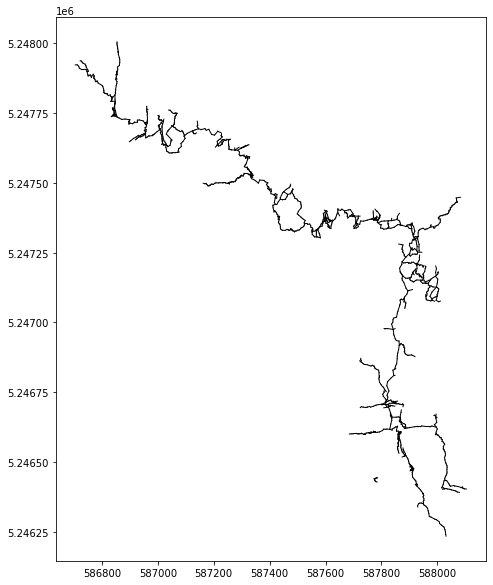

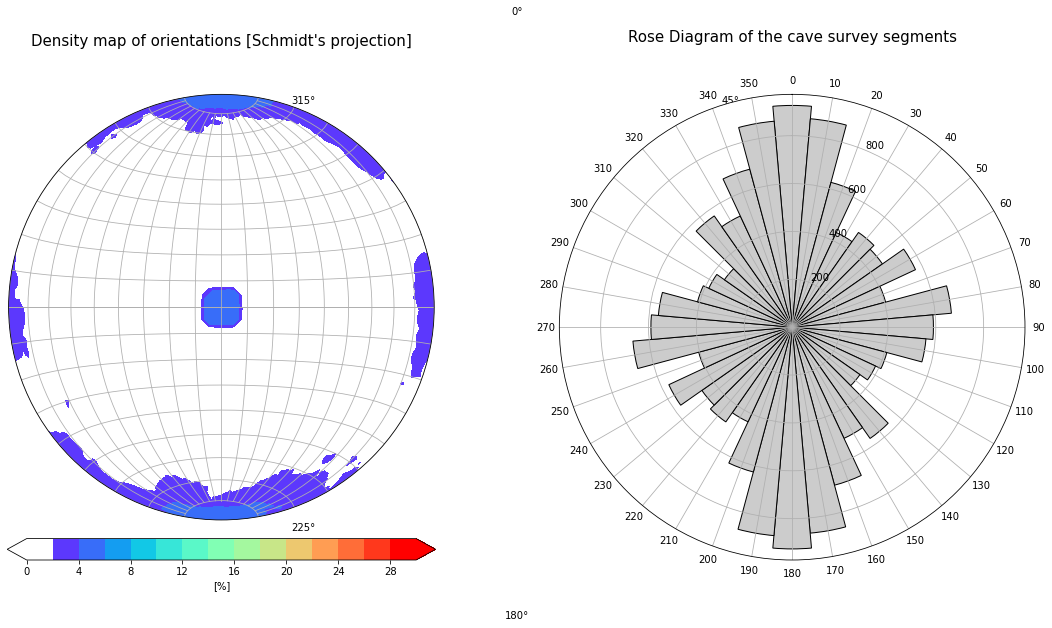


 This network contains :
 1714  nodes (stations) and  1752  edges.
  On the simplified graph, there are :  351  nodes (stations) and  395  edges,
 135  are extremity nodes (entries or exits) and  193  are junction nodes.
There is/are  1  connected component.s and  45  cycle.s.


Howard's parameter are (Howard, 1970) :  
 alpha:  0.06456241032998565 
 beta 1.1253561253561253 
 gamma 0.3772683858643744

Note that this computation considers the node of degree 2  necessary to loop preservations as Seed Nodes, in order to  stay consistent with Howard's illustrations.
Computing:
 - mean length,cv length,length entropy,mean tortuosity

 - orientation entropy,aspl,cpd,md,cv degree,cvd


{'mean length': 57.42285774845878,
 'cv length': 4.00842659681307,
 'length entropy': 0.03658296347350062,
 'tortuosity': 1.272714613721442,
 'orientation entropy': 0.9841546675878691,
 'aspl': 22.386357346357347,
 'cpd': 0.45559258990702406,
 'mean degree': 2.2507122507122506,
 'cv degree': 0.4796701833442699,
 'correlation vertex degree': -0.29799284035634255}

In [84]:
[holloch,holloch_nodes,holloch_edges,ax] = load_network('inputs/paper3/holloch3D', clean=True, plot=True)
holloch.stereo()                                          #plot stereonet & rose diagram
holloch.basic_analysis()
holloch.characterize_graph()

## Hypothesis 1: glaciation ##
Only the paleo-spring is active (all other springs are covered by the glacier).<br>
Inlet N21 (farthest SW) is inactive (covered by glacier). <br>
Inlet N16 (Mahdtal) is inactive (covered by glacier), and is replaced by an inlet at the Hölloch cave entrance (N18).<br>
Inlet N1 is disconnected from the rest of the system and drains to a small spring in Ifenmulde (QI).

CAUTION: You are using the development version of this package.

 This network contains  2  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd


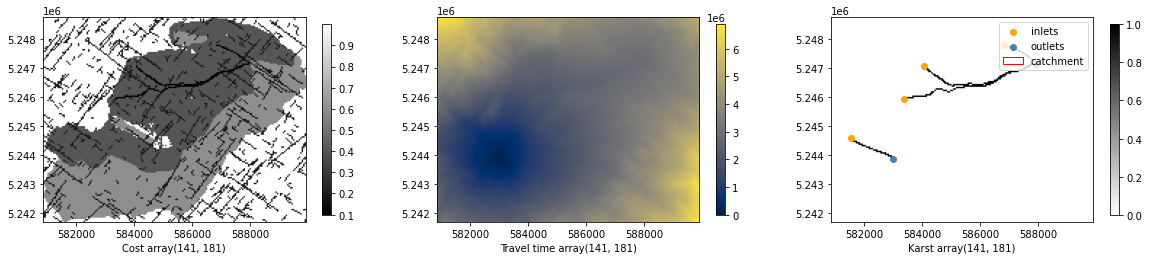

In [194]:
#Load model and simulate anisotropic network with multiple springs:
add_outlet = True                                                                #add separate outlet for Ifersguntenalpe subcatchment

catchment = pk.SKS('inputs/paper3/settings_new.yaml')                               #import settings and options from input folder
catchment.set_geological_datafile('inputs/paper3/simplegeo_glacier181x141.csv')     #replace geology with new file including glacier
catchment.set_geology_id([0,1,2,3])                                                 #add glacier id
catchment.set_geology_cost([catchment.settings['cost_out'], catchment.settings['cost_aquiclude'], 
                            catchment.settings['cost_aquifer'], catchment.settings['cost_aquiclude']])
if add_outlet:
    catchment.set_inlets_data('inputs/paper3/inlets2D_hypothesis1b.txt')    #load new inlet file
    catchment.set_outlets_data('inputs/paper3/outlets2D_hypothesis1b.txt')  #load new outlet file with separate spring for Ifersguntenalpe
    catchment.set_outlets_importance([1,1])                                 #each outlet in its own iteration
    catchment.set_inlets_per_outlet([4,1])                                  #first four inlets to overflow, last inlet to Ifersguntenalpe
    catchment.set_inlets_importance([1])                                    #can only do one inlet iteration because last outlet onlyhas one inlet - NEED TO FIX IN NEXT VERSION
else:
    catchment.set_inlets_data('inputs/paper3/inlets2D_hypothesis1_gempy.txt')   #load new inlet file
    catchment.set_outlets_data('inputs/paper3/outlets2D_hypothesis1.txt')       #load new outlet file with ONLY overflow spring
    catchment.set_outlets_importance([1])                                       #only one outlet to iterate over
    catchment.set_inlets_per_outlet([1])                                        #only one outlet to iterate over
    catchment.set_inlets_importance([2,1,1])                                    #run first two inlets together, then each remaining in its own timestep
catchment.update_all()                                                          #update model for changes to take effect
catchment.compute_karst_network()                                               #run the model to calculate the karst network
catchment.show() 


 This network contains  1  connected components

Graph successfully created from file !



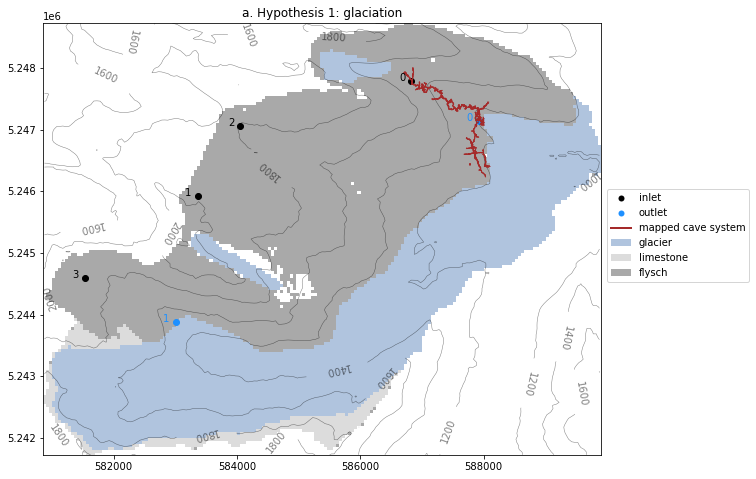

In [89]:
## Create a clean map describing Hypothesis 1 without showing any conduit simulations

f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111, aspect='equal')  
ax.set_title('a. Hypothesis 1: glaciation')

cmap_glac = matplotlib.colors.ListedColormap(['white','gainsboro','darkgrey','lightsteelblue'])   #geology colormap
faults = catchment.get_faults().copy()                                           #get faults array
faults[faults<1] = -1                                                            #set non-fault cells to not display
frac = catchment.get_fractures().copy()                                           #get faults array
frac[frac<1] = -1                                                            #set non-fault cells to not display

plt.imshow(catchment.get_geology(), origin='lower', extent=catchment.grid.extent, cmap=cmap_glac)
#plt.imshow(faults,                  origin='lower', extent=catchment.grid.extent, cmap=cmap_frac,  vmin=0,vmax=1)
#plt.imshow(frac,                    origin='lower', extent=catchment.grid.extent, cmap=cmap_frac,  vmin=0,vmax=1)
c = plt.contour(catchment.grid.X,catchment.grid.Y, catchment.geology.data['topography']['data'], colors=['k'], alpha=0.5, linewidths=0.5)
plt.clabel(c, inline=True, inline_spacing=20, fontsize=10, fmt='%1.0f', rightside_up=False, use_clabeltext=True)
#load_network(data='inputs/gottesacker/base', plot=True, ax=ax, alpha=0.5)                                                 #plot base network
load_network('inputs/paper3/holloch3D', clean=True, plot=True, ax=ax, color='brown')
#catchment.show_network(ax=ax, data=catchment.karst_simulations[0], simplify=False, labels=[], plot_nodes=False, legend=False, color='k')
plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')  
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')
#plt.scatter([582880.85],[ 5243055.12  ], c='k')                                                     #plot covered inlet
#plt.scatter([588979.5, 587747.52, 588123.61],[5246730.86, 5244963.63, 5245638.24], c='dodgerblue')  #plot covered springs

label = True
if label:
    outlet_labels = ['QO', 'QI']                                                      #overflow, ifersguntenalpe
    for i,inlet in enumerate(catchment.inlets):
        ax.annotate(str(i), xy=(inlet[0]-200, inlet[1]))                              # annotate with inlet iteration order 
    for o,outlet in enumerate(catchment.outlets):
        #ax.annotate(outlet_labels[o], xy=(outlet[0]+100, outlet[1]), c='dodgerblue') #uncomment to annotate with name
        ax.annotate(str(o), xy=(outlet[0]-200, outlet[1]), c='dodgerblue')            #uncomment to annotate with outlet iteration order

legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='k', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='dodgerblue', markeredgecolor='none', label='outlet'),
          #matplotlib.lines.Line2D([0], [0], color='k',     lw=2,   label='simulated network'),
          #matplotlib.lines.Line2D([0], [0], color='gray',  lw=2,   label='reference network'),
          matplotlib.lines.Line2D([0], [0], color='brown', lw=2,   label='mapped cave system'),
          #matplotlib.lines.Line2D([0], [0], color='gray',  lw=0.5, label='contour'),
          matplotlib.patches.Patch(facecolor='lightsteelblue', label='glacier'),
          #matplotlib.patches.Patch(facecolor='whitesmoke', label='fractures'),
          matplotlib.patches.Patch(facecolor='gainsboro',  label='limestone'),
          matplotlib.patches.Patch(facecolor='darkgray',   label='flysch')]
plt.legend(handles=legend, loc=[1.01, 0.4]) #to put on right side: loc=[1.01,0.5], to put in right corner: loc=[0.72,0.01], to put in left corner: loc=[0.01,0.01]


In [15]:
#### Iterate over many versions:
shuffle    = False  #shuffle inlet/outlet order?
add_outlet = True   #add separate spring for ifersguntenalpe subcatchment?
n = 100             #number of iterations to calculate (caution: more than 10 is slow)

catchment = pk.SKS('inputs/paper3/settings_new.yaml')                               #import settings and options from input folder
catchment.set_geological_datafile('inputs/paper3/simplegeo_glacier181x141.csv')     #set geologic map
catchment.set_geology_id([0,1,2,3])                                         #add glacier id to list of formations
catchment.set_cost_aquiclude(0.8)                                           #increase travel cost in aquiclude (glacier is classified as aquiclude)

catchment.set_geology_cost([catchment.settings['cost_out'], catchment.settings['cost_aquiclude'], 
                            catchment.settings['cost_aquifer'], catchment.settings['cost_aquiclude']])
if add_outlet:
    catchment.set_inlets_data('inputs/paper3/inlets2D_hypothesis1b.txt')    #load new inlet file
    catchment.set_outlets_data('inputs/paper3/outlets2D_hypothesis1b.txt')  #load new outlet file with separate spring for Ifersguntenalpe
    catchment.set_outlets_importance([1,1])                                 #each outlet in its own iteration
    catchment.set_inlets_per_outlet([4,1])                                  #first four inlets to overflow, last inlet to Ifersguntenalpe
    catchment.set_inlets_importance([1])                                    #can only do one inlet iteration because last outlet onlyhas one inlet - NEED TO FIX IN NEXT VERSION
else: 
    catchment.set_inlets_data('inputs/paper3/inlets2D_hypothesis1_gempy.txt')   #load new inlet file
    catchment.set_outlets_data('inputs/paper3/outlets2D_hypothesis1.txt')       #load new outlet file
    catchment.set_outlets_importance([1])                                       #only one outlet to iterate over
    catchment.set_inlets_per_outlet([1])                                        #only one outlet to iterate over
    catchment.set_inlets_importance([2,1,1])                                    #first two inlets at same time, then each remaining in its own iteration
if shuffle:
    catchment.set_inlets_shuffle(True)                                          #shuffle inlet order each run
                                                    
start = time.perf_counter()                                            #start timer
for i in range(n):
    catchment.update_all()                                             #update model for changes to take effect
    catchment.compute_karst_network() 
end = time.perf_counter()                                              #end timer
print('Computation time:', end - start, 'sec')                         #subtract start time from end time to see how long it took

CAUTION: You are using the development version of this package.

 This network contains  2  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  2  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  2  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  2  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  2  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  2  connected components

Computing:
 - mean length,cv length,length entropy,mean 

shuffle =  False
add outlet =  True

 This network contains  1  connected components

Graph successfully created from file !



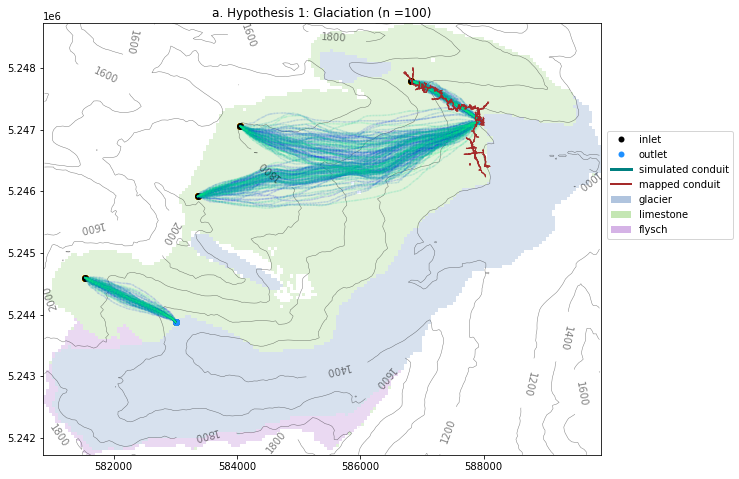

In [16]:
#Plot many iterations:
print('shuffle = ', shuffle)
print('add outlet = ', add_outlet)
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111, aspect='equal')
ax.set_title('a. Hypothesis 1: Glaciation (n ='+str(n)+')')

plt.imshow(catchment.get_geology(), origin='lower', extent=catchment.grid.extent, cmap=cmap_geo, alpha=0.5)
c = plt.contour(catchment.grid.X,catchment.grid.Y, catchment.geology.data['topography']['data'], colors=['k'], alpha=0.5, linewidths=0.5)
plt.clabel(c, inline=True, inline_spacing=20, fontsize=10, fmt='%1.0f', rightside_up=False, use_clabeltext=True)
for i in range(n):
    color = matplotlib.cm.winter(i/n)
    alpha = 10/n
    catchment.show_network(ax=ax, data=catchment.karst_simulations[i], simplify=False, labels=[], plot_nodes=False, legend=False, color=color, alpha=alpha)
load_network('inputs/paper3/holloch3D', clean=True, plot=True, ax=ax, color=cave)
plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c=water)
#ax.annotate('QO', xy=(catchment.outlets[:,0]+100, catchment.outlets[:,1]), c=water)

label = False
if label:
    for i,inlet in enumerate(catchment.inlets):
        ax.annotate(str(i), xy=(inlet[0]+100,inlet[1]+100),color='k')

legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='k', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor=water, markeredgecolor='none', label='outlet'),
          matplotlib.lines.Line2D([0], [0], color=conduits, lw=3,      label='simulated conduit'),
          matplotlib.lines.Line2D([0], [0], color=cave,     lw=2,      label='mapped conduit'),
          matplotlib.patches.Patch(facecolor=ice,       label='glacier'),
          matplotlib.patches.Patch(facecolor=limestone, label='limestone'),
          matplotlib.patches.Patch(facecolor=flysch,    label='flysch')]
plt.legend(handles=legend, loc=[1.01, 0.5])

In [7]:
catchment.compare_stats()



STATS for modelisation
Var       Value       Min ref     Max ref     Result      
------------------------------------------------------
CPD       0.271       0.022       0.572       IN          
CVk       0.325       0.351       0.592       out -       
CVl       1.808       0.898       2.555       IN          
H0        0.804       0.491       0.997       IN          
Hl        0.402       0.086       0.694       IN          
SPL       6.652       2.321       55.722      IN          
kmoy      2.333       1.75        2.569       IN          
rk        -0.179      -0.556      -0.15       IN          


## Hypothesis 2: Sagebach covered ##
The network is the same in all respects except that only the Sagebach spring is covered by overlying units.

CAUTION: You are using the development version of this package.

 This network contains  2  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd


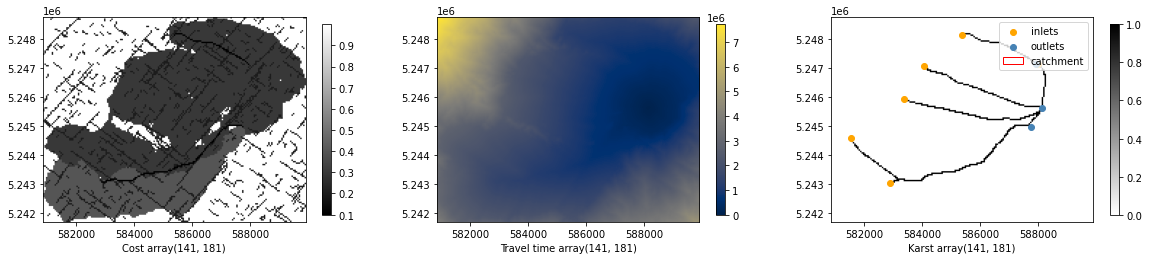

In [154]:
#Load model and simulate anisotropic network with multiple springs:
catchment = pk.SKS('inputs/paper3/settings_new.yaml')                     #import settings and options from input folder
catchment.set_geological_datafile('inputs/paper3/simplegeo181x141.csv')     #replace gempy geology with arcmap geology
catchment.set_inlets_data('inputs/paper3/inlets2D_hypothesis2b.txt')   #load new inlet file - explicit QO-QA connection
catchment.set_outlets_data('inputs/paper3/outlets2D_hypothesis2b.txt') #load new outlet file
catchment.set_outlets_importance([1,1,1])                             #assign each outlet to an iteration (3 outlets total)
#catchment.set_inlets_per_outlet([1,1,3])                              #distribute inlets evenly between outlets
catchment.set_inlets_per_outlet([1,1,4])                             #hypothesis 2b (QO-QA connection exists)
catchment.set_inlets_importance([1])                                  #assign all inlets to a single iteration (5 inlets total)
catchment.update_all()                                                #update model for changes to take effect
catchment.compute_karst_network()                                     #run the model to calculate the karst network
catchment.show()


 This network contains  1  connected components

Graph successfully created from file !



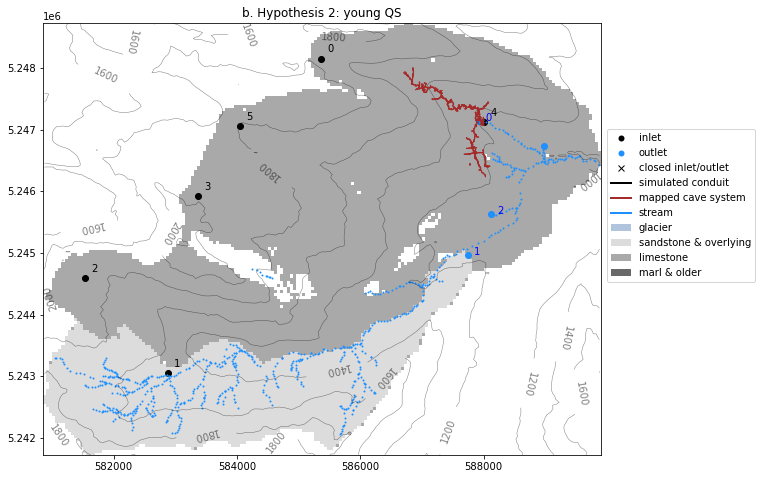

In [95]:
## Plot a clean figure showing the system configuration under Hypothesis 2 with no conduit network simulations

f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111, aspect='equal')  
ax.set_title('b. Hypothesis 2: young QS')

faults = catchment.get_faults().copy()                                           #get faults array
faults[faults<1] = -1                                                            #set non-fault cells to not display
frac = catchment.get_fractures().copy()                                           #get faults array
frac[frac<1] = -1                                                            #set non-fault cells to not display


plt.imshow(catchment.get_geology(), origin='lower', extent=catchment.grid.extent, cmap=cmap_geo)
#plt.imshow(faults,                  origin='lower', extent=catchment.grid.extent, cmap=cmap_frac,     vmin=0,vmax=1)
#plt.imshow(frac,                    origin='lower', extent=catchment.grid.extent, cmap=cmap_frac,     vmin=0,vmax=1)
c = plt.contour(catchment.grid.X,catchment.grid.Y, catchment.geology.data['topography']['data'], colors=['k'], alpha=0.5, linewidths=0.5)
plt.clabel(c, inline=True, inline_spacing=20, fontsize=10, fmt='%1.0f', rightside_up=False, use_clabeltext=True)
#load_network('inputs/gottesacker/base', plot=True, ax=ax, alpha=0.5)                                                 #plot base network
load_network('inputs/paper3/holloch3D', clean=True, plot=True, ax=ax, color='brown')
#catchment.show_network(ax=ax, data=catchment.karst_simulations[0], simplify=False, labels=[ ], plot_nodes=False, legend=False, color='k')
plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')  
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c='dodgerblue')
plt.scatter([588979.5  ],[5246730.86], c='dodgerblue')
plt.scatter(streams[:,0], streams[:,1], c='dodgerblue', s=1)


label = True
if label:
    for i,inlet in enumerate(catchment.inlets):
        ax.annotate(str(i), xy=(inlet[0]+100,inlet[1]+100),color='k')
    for o,outlet in enumerate(catchment.outlets):
        ax.annotate(str(o), xy=(outlet[0]+100,outlet[1]),color='b')

legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='k', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='dodgerblue', markeredgecolor='none', label='outlet'),
          matplotlib.lines.Line2D([0], [0], marker='x', color='none', markerfacecolor='k', markeredgecolor='k', label='closed inlet/outlet'),
          matplotlib.lines.Line2D([0], [0], color='k',     lw=2,   label='simulated conduit'),
          #matplotlib.lines.Line2D([0], [0], color='gray',  lw=2,   label='reference network'),
          matplotlib.lines.Line2D([0], [0], color='brown', lw=2,   label='mapped cave system'),
          matplotlib.lines.Line2D([0], [0], color='dodgerblue', lw=2,   label='stream'),
          #matplotlib.lines.Line2D([0], [0], color='gray',  lw=0.5, label='contour'),
          #matplotlib.patches.Patch(facecolor='whitesmoke', label='fractures'),
          matplotlib.patches.Patch(facecolor='lightsteelblue', label='glacier'),
          matplotlib.patches.Patch(facecolor='gainsboro', label='sandstone & overlying'),
          matplotlib.patches.Patch(facecolor='darkgray',  label='limestone'),
          matplotlib.patches.Patch(facecolor='dimgrey',   label='marl & older')]
plt.legend(handles=legend, loc=[1.01,0.4]) #to put on right side: loc=[1.01,0.5], to put in right corner: loc=[0.72,0.01], to put in left corner: loc=[0.01,0.01]


In [13]:
#Iterate over many versions:
shuffle = False
catchment = pk.SKS('inputs/paper3/settings_new.yaml')
catchment.set_geological_datafile('inputs/paper3/simplegeo181x141.csv')     #replace gempy geology with arcmap geology
catchment.set_inlets_data('inputs/paper3/inlets2D_hypothesis2b.txt')   #load new inlet file
catchment.set_outlets_data('inputs/paper3/outlets2D_hypothesis2b.txt') #load new outlet file
catchment.set_outlets_importance([1,1,1])                             #each outlet with its own iteration
#catchment.set_inlets_per_outlet([1,1,3])                              #distribute inlets if there is no inlet at QO
catchment.set_inlets_per_outlet([1,1,4])                              #distribute inlets if there is an inlet colocated with QO
catchment.set_inlets_importance([1])                                  #all inlets in a single iteration per outlet

if shuffle:
    catchment.set_inlets_shuffle(True)                                    #shuffle inlet order each run
    catchment.set_outlets_shuffle(True)                                   #shuffle outlet order each run

n = 100                                                                #number of iterations to calculate (caution: more than 10 is slow)
for i in range(n):
    catchment.update_all()                                            #update model for changes to take effect
    catchment.compute_karst_network() 

CAUTION: You are using the development version of this package.

 This network contains  2  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  2  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  2  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  2  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  2  connected components

Computing:
 - mean length,cv length,length entropy,mean tortuosity
 - orientation entropy,aspl,cpd,md,cv degree,cvd

 This network contains  2  connected components

Computing:
 - mean length,cv length,length entropy,mean 

shuffle =  False

 This network contains  1  connected components

Graph successfully created from file !



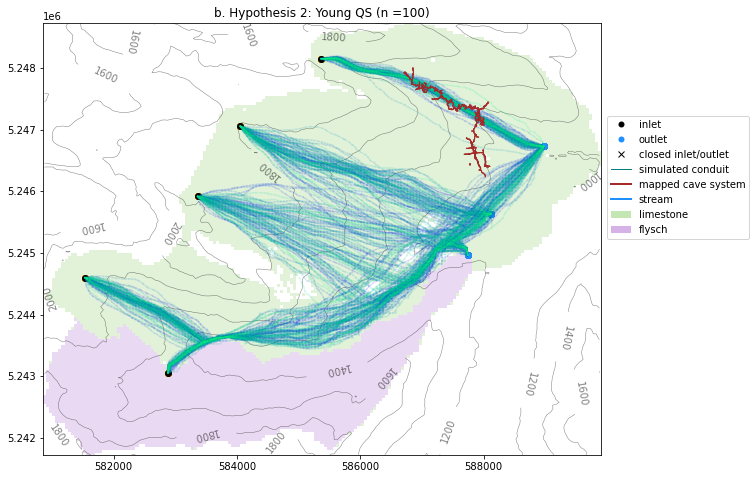

In [20]:
#Plot many iterations:
print('shuffle = ', shuffle)
f = plt.figure(figsize=(10,10))
ax = f.add_subplot(111, aspect='equal')
ax.set_title('b. Hypothesis 2: Young QS (n ='+str(n)+')')

plt.imshow(catchment.get_geology(), origin='lower', extent=catchment.grid.extent, cmap=cmap_geo,alpha=0.5, vmax=3)
c = plt.contour(catchment.grid.X,catchment.grid.Y, catchment.geology.data['topography']['data'], colors=['k'], alpha=0.5, linewidths=0.5)
plt.clabel(c, inline=True, inline_spacing=20, fontsize=10, fmt='%1.0f', rightside_up=False, use_clabeltext=True)
for i in range(n):
    color = matplotlib.cm.winter(i/n)
    alpha = 10/n
    catchment.show_network(ax=ax, data=catchment.karst_simulations[i], simplify=False, labels=[], plot_nodes=False, legend=False, color=color, alpha=alpha)
load_network('inputs/paper3/holloch3D', clean=True, plot=True, ax=ax, color=cave)
plt.scatter(catchment.inlets[:,0],  catchment.inlets[:,1],  c='k')
plt.scatter(catchment.outlets[:,0], catchment.outlets[:,1], c=water)

legend = [matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor='k', markeredgecolor='none', label='inlet'),
          matplotlib.lines.Line2D([0], [0], marker='o', color='none', markerfacecolor=water, markeredgecolor='none', label='outlet'),
          matplotlib.lines.Line2D([0], [0], marker='x', color='none', markerfacecolor='k', markeredgecolor='k', label='closed inlet/outlet'),
          matplotlib.lines.Line2D([0], [0], color=conduits, lw=1,   label='simulated conduit'),
          matplotlib.lines.Line2D([0], [0], color=cave, lw=2,   label='mapped cave system'),
          matplotlib.lines.Line2D([0], [0], color=water,lw=2,   label='stream'),
          matplotlib.patches.Patch(facecolor=limestone, label='limestone'),
          matplotlib.patches.Patch(facecolor=flysch,    label='flysch')]
plt.legend(handles=legend, loc=[1.01,0.5])

In [10]:
catchment.compare_stats()



STATS for modelisation
Var       Value       Min ref     Max ref     Result      
------------------------------------------------------
CPD       0.295       0.022       0.572       IN          
CVk       0.35        0.351       0.592       out -       
CVl       2.153       0.898       2.555       IN          
H0        0.876       0.491       0.997       IN          
Hl        0.32        0.086       0.694       IN          
SPL       13.585      2.321       55.722      IN          
kmoy      2.438       1.75        2.569       IN          
rk        -0.344      -0.556      -0.15       IN          
